<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_7_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembles and Error Measures

In this lab we will focus on Random Forest and XGBoosting methods created over the original data. For this, we will first import the data and re-train our original logistic regression.



## Imports and preparation

In [1]:
# Import the csv files from last week.
!gdown 'https://drive.google.com/uc?id=1LWRFLpJtTopAlRqTuUd9XZvGB6CoHa2z'
!gdown 'https://drive.google.com/uc?id=1IvY78EGu-eizec_9agJUsQWDLT-wmSHF'
!gdown 'https://drive.google.com/uc?id=1aDraDSR2OQbIMjIY07s-rD5cel2x_iS-'

Downloading...
From: https://drive.google.com/uc?id=1LWRFLpJtTopAlRqTuUd9XZvGB6CoHa2z
To: /content/test_woe.csv
100% 80.6k/80.6k [00:00<00:00, 29.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IvY78EGu-eizec_9agJUsQWDLT-wmSHF
To: /content/train_woe.csv
100% 188k/188k [00:00<00:00, 58.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aDraDSR2OQbIMjIY07s-rD5cel2x_iS-
To: /content/BankloanCleanNewVars.pkl
100% 144k/144k [00:00<00:00, 41.4MB/s]


In [2]:
!pip install scorecardpy

In [3]:
# Package loading
import pandas as pd
import numpy as np
import scorecardpy as sc

In [4]:
# Import the files as Pandas datasets
bankloan_train_WoE = pd.read_csv('train_woe.csv')
bankloan_test_WoE = pd.read_csv('test_woe.csv')
bankloan_data = pd.read_pickle('BankloanCleanNewVars.pkl')

# Eliminate unused variables
bankloan_train_WoE.drop(columns=['OthDebt_woe'], inplace = True)
bankloan_test_WoE.drop(columns=['OthDebt_woe'], inplace = True)

# Same train-test split as before (because of seed!)
bankloan_train_noWoE, bankloan_test_noWoE = sc.split_df(bankloan_data.iloc[:, 1:],
                                                        y = 'Default',
                                                        ratio = 0.7,
                                                        seed = 20190227).values()

# Give breaks for WoE
breaks_adj = {'Address': [1.0,2.0,8.0,17.0],
              'Age': [30.0,45.0,50.0],
              'Creddebt': [1.0, 6.0],
              'Employ': [4.0,14.0,22.0],
              'Income': [30.0,40.0,80.0,140.0],
              'Leverage': [8.0,16.0,22.0],
              'MonthlyLoad': [0.1,0.2,0.30000000000000004,0.7000000000000001],
              'OthDebtRatio': [0.1]
              }

# Apply breaks.
bins_adj = sc.woebin(bankloan_train_noWoE, y="Default",
                     breaks_list=breaks_adj)

[INFO] creating woe binning ...


In [5]:
# Train logistic regression
from sklearn.linear_model import LogisticRegressionCV

bankloan_logreg = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge
                                     Cs = 10,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.0001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=0, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = 2,      # Processes to use. Set to number of physical cores. 
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1, 0.1)
                                    )

bankloan_logreg.fit(X = bankloan_train_WoE.iloc[:, 1:], # All rows and from the second var to end
                    y = bankloan_train_WoE['Default'] # The target
                   )

# Calculate scorecard
bankloan_sc = sc.scorecard(bins_adj, bankloan_logreg, 
             bankloan_train_WoE.columns[1:], # The column names in the trained LR
             points0=750, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 

# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(bankloan_train_noWoE, bankloan_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(bankloan_test_noWoE, bankloan_sc, 
                               print_step=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Random Forests

Now we will train a random forest. It is included in the ```sklearn.ensemble``` subpackage, function [```RandomForestClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), so it is straightforward to use. It comes with many parameters, but in general there is a philosophy to follow:

- In a Random Forest we want each tree to be large, and to learn as much as possible from its subset of data. We don't care too much if each tree is overadjusted, as we can always increase the number of trees to take care of this.

- This said, a good idea is to limit the minimum number of samples per leaf when we have few cases (this is not usually a problem in large datasets).

- We might want to limit the minimum impurity decrease to stop growing a tree if not much is happening.

- There is also a class weight to include. It does include one automatically if we use the option ```balanced```.

Let's train one and check the options.

In [6]:
from sklearn.ensemble import RandomForestClassifier

#Define the classifier
bankloan_rf = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='entropy', # How to train the trees. Also supports gini.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.0001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.00001, # Minimum impurity decrease. This is 10^-4.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=2, # Parallel processing. Set to the number of cores you have. Watch your RAM!!
                       random_state=20190305, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced' # Balance the classes.
                                    )

Now we are ready to train. We just give it our original training set variables and target.

In [7]:
# Train the RF.
bankloan_rf.fit(bankloan_train_noWoE.iloc[:,:-1], # X 
               bankloan_train_noWoE['Default']    # y
                )  

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    3.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=0.0001, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=2, oob_score=True, random_state=20190305,
                       verbose=1, warm_start=False)

We can see it used two jobs (two processors are available to us in this Google Colab server). It converges very quickly. Let's check how it did, this time we will print a nicer confusion matrix using seaborn, and will plot the ROC curve of the model. 

In [8]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# Apply the model to the test set.
rf_pred_class_test = bankloan_rf.predict(bankloan_test_noWoE.iloc[:, :-1])
rf_probs_test = bankloan_rf.predict_proba(bankloan_test_noWoE.iloc[:, :-1])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished


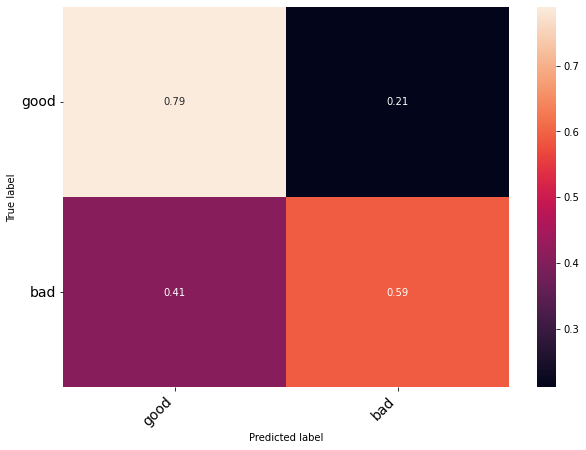

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = bankloan_test_noWoE['Default'], 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Looks a bit unbalanced, but otherwise ok. It's harder to predict the  defaulters. Now let's see the ROC curve.

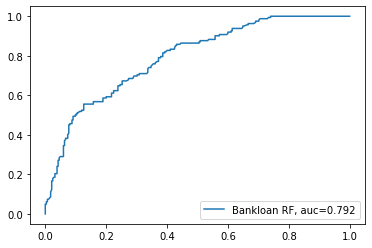

In [10]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], rf_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Now, let's print the variable importance. The importance is calculated by averaging the accuracy of trees when the variables is included the tree, and comparing it to when it's NOT included the tree.

In [11]:
bankloan_train_noWoE.iloc[:, :-1].columns

Index(['Age', 'Employ', 'Address', 'Income', 'Leverage', 'Creddebt', 'OthDebt',
       'MonthlyLoad', 'OthDebtRatio'],
      dtype='object')

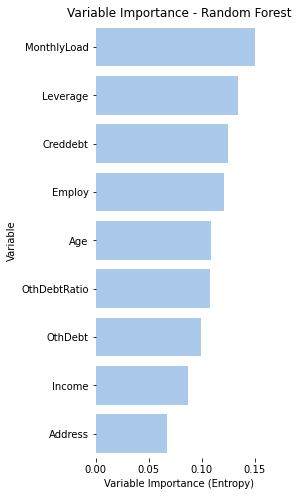

In [12]:
# Plot variable importance
importances = bankloan_rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

That's it! Now we'll compare this with an XGBoost and see which one of our three models is better.


## XGBoosting

The stochastic gradient boosting model is the alternative to Random Forest. Now we want to create a series of small trees, which will be poorer in performance, but together they will be stronger. Training an XGBoost model is harder, because we need to control the model so it creates small trees, but it performs better in small data, something Random Forests do not necessarily accomplish.

While scikit-learn does have its own implementation of XGB ([```sklearn.ensemble```](https://scikit-learn.org/stable/modules/ensemble.html)), there are a couple of very strong packages out there that implement the algorithm. ```xgboost``` and ```lightgbm``` are two of the best known ones. We will use [```xgboost```](https://xgboost.readthedocs.io/en/latest/python/) for this lab, available pretty much for every language out there.

The first step is to define a classifier that we will use.

In [13]:
from xgboost import XGBClassifier
#Define the classifier.
XGB_Bankloan = XGBClassifier(max_depth=2,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=50,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights. G / B
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201108,        # Seed
                            missing=None,                 # How are nulls encoded?
                            #tree_method='gpu_hist',       # How to train the trees?
                            #gpu_id=0                      # With which GPU? 
                            )

This classifier can be used to tune the parameters of the model. We will use sklearn's ```GridSearchCV``` for this. It requires a dictionary of the parameters to look for. We will tune the number of trees (XGB overfits relatively easily, always tune this), the depth, and the learning rate.

In [14]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

This training process can be very large. We will create a validation set for the sample.

In [15]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = bankloan_train_noWoE.sample(frac = 0.5,               # The fraction to extract
                                       random_state = 20201108,    # The seed.
                                       )

Now we can do a grid search over the parameter space. We will use the AUC (as this is a binary classification problem)

In [16]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_Bankloan,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = 2,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [17]:
# Train grid search.
GridXGB.fit(val_train.iloc[:, :-1], val_train['Default'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:  2.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.001,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=50, n_jobs=2,
                                     nthread=None, objective='binary:logistic',
                                     random_state=20201108, reg_alpha=1,
                                     reg_lambda=0, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=0.632,
                                     verbosity=1),
             iid='deprecated', n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
             

Now we can output the optimal parameters.

In [18]:
# Show best params
print('The best AUC is %.3f' % GridXGB.best_score_)
GridXGB.best_params_

The best AUC is 0.808


{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}

It is telling us to use 1% learning rate with a max_depth of 2 and 150 trees. As the n_estimators parameter is at the limit, I would run again with a depth of four just to check one further the limit. I leave this as an exercise.

Now we can fit the final model!

In [25]:
# Create XGB with best parameters.
XGB_Bankloan = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            #n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None,                 # How are nulls encoded?
                            tree_method='gpu_exact',       # How to train the trees?
                            gpu_id=0                      # With which GPU?
                            )

In [26]:
# Train over all training data.
XGB_Bankloan.fit(bankloan_train_noWoE.iloc[:, :-1], bankloan_train_noWoE['Default'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=0,
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=20201107,
              reg_alpha=1, reg_lambda=0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.632, tree_method='gpu_exact',
              verbosity=1)

Now we can evaluate our model. First we calculate the variable importance.

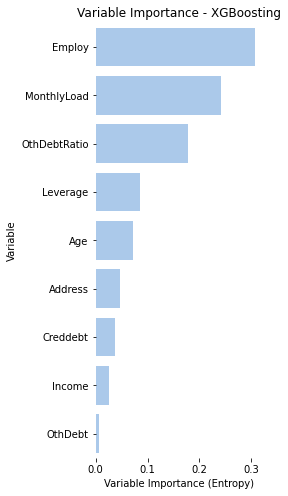

In [27]:
# Plot variable importance
importances = XGB_Bankloan.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[bankloan_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

What do you see here? Does it make sense to you?

Let's finish by plotting the evaluation measures. How does it compare to Random Forest? Why do you think this is?

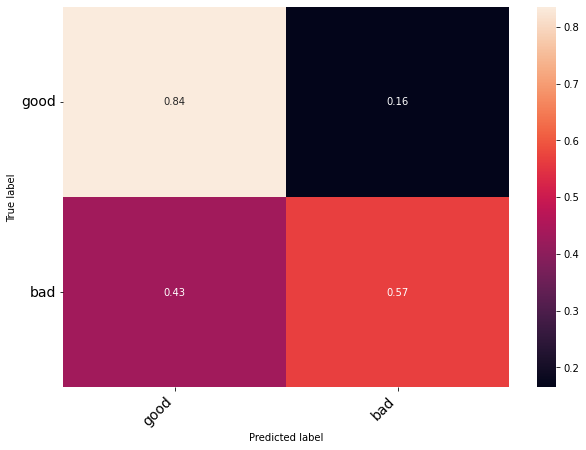

In [28]:
# Calculate probability
XGBClassTest = XGB_Bankloan.predict(bankloan_test_noWoE.iloc[:, :-1])
xg_probs_test = XGB_Bankloan.predict_proba(bankloan_test_noWoE.iloc[:, :-1])
xg_probs_test = xg_probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = bankloan_test_noWoE['Default'], 
                    y_pred = XGBClassTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Very similar results. Now there is no chance to use sample weights sadly, so the solution is a bit more unbalanced. This is not too much of an issue though, as we can always change the cutoff point to account for the unbalance.

Let's check the ROC curve.

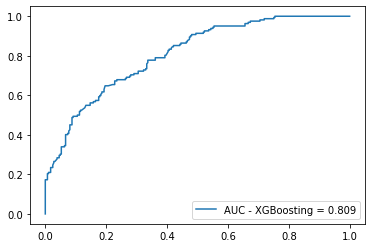

In [29]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(bankloan_test_noWoE['Default'], 
                                 xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = xg_probs_test),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

## TreeSHAP

The variable importance plots are quite useful to get a first look at the impact of each variable in the model. However, there is a much better way of doing this using the well-known Shapley Values. The method, adapted to tree models, is called [SHAP](https://github.com/slundberg/shap). It works by using a game-theoretical approach to comparing when the variable is in a model versus when it is not. The technical details are published in [this paper](https://www.nature.com/articles/s42256-019-0138-9).

The method requires an already trained XGB model. The package is fairly comprehensive, but we will focus on these two elements:


1. How to measure the average impact of each variables on a sample of cases (the most important application!).

2. How to measure the impact of each variable on prediction.

Reading the documentation will allow you to make other plots.

Let's start with loading the package.

In [30]:
!pip install shap

In [31]:
import shap
shap.initjs() # Import Java engine.

Now, let's calculate the Shapley scores.

In [34]:
# Trains the game-theoretic model. Really complex so requires sampling.
explainer = shap.TreeExplainer(XGB_Bankloan,                         # The model    
                              data = shap.sample(bankloan_train_noWoE.iloc[:, :-1],
                                                 100)  # Create a sample of 100 cases
                              )

# Applies model ot the full dataset.
shap_values = explainer.shap_values(bankloan_train_noWoE.iloc[:, :-1],
                                    check_additivity=False)

Now we can run the first plot. We will calculate the contribution to explanations for all points in the sample.

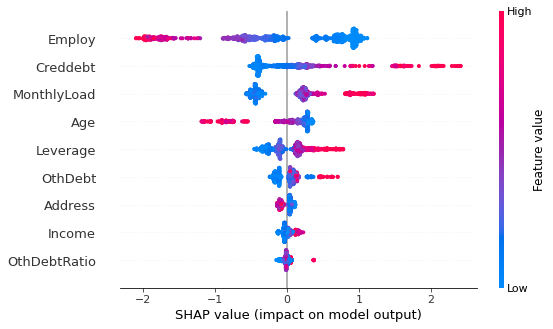

In [44]:
shap.summary_plot(shap_values,                       # The Shapley values.
                  bankloan_train_noWoE.iloc[:, :-1], # The training sample
                  show=False)                        # Whether to print the model or not

# Let's save this as a PDF for later use.
plt.savefig('ShapSummaryPlot.pdf', dpi=300, bbox_inches='tight')
plt.show()

How to read this plot? It follows a similar logic to reading WoEs#

1. The absolute value of the Shapley value (x-axis) is how important the variable is for predicting, while the sign says whether the prediction is towards a positive value (Defaulters in this case) or a zero value (non-defaulters).

2. The colour in the plot says whether the feature value is high or low for that Shapley score.

3. The y-axis shows all variables ordered from more useful to less useful in predicting.

So, for example, let's consider Employ. This variable represents years of employment. We can see that high values are related to very high Shapley values, meaning that high values are very helpful (in fact, the most helpful of all sets of values in the dataset) to predict non-defaulters, while low values are helpful to predict defaulters, but not as much. Here the non-linear behaviour of the variable is shown quite clearly!

Now, let's dig in the impact of each variable.

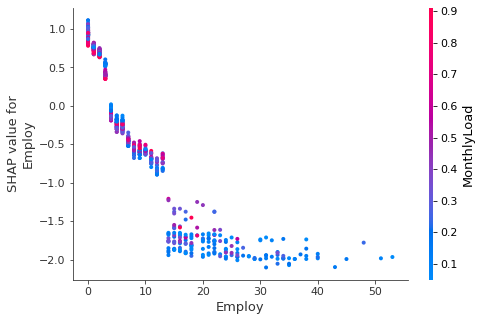

In [45]:
shap.dependence_plot("Employ",                          # The variable to study
                     shap_values,                       # The Shapley values.
                     bankloan_train_noWoE.iloc[:, :-1], # The training sample
                     show=False)                        # Whether to print the model or not

plt.savefig('ShapEmploy.pdf', dpi=300, bbox_inches='tight')
plt.show()

This plot shows the value of the variable in the X-axis and compares it with the value of the Shap coefficient in the Y-axis. The colour now represents the value of the most correlated variable in the dataset (in this case, MonthlyLoad) and it is given for reference only.

In this plot, we can see how after 10 years of employment the people are strongly non-defaulters (with Shap values of around -1.5 to -2) while the neutral point (Shap value of 0) is around 3 years. Anything below 3 years helps the most in predicting defaulters. There does not seem to be much correlation with MonthlyLoad, so we are fairly sure this variable is independently predicting what it does.

Now you can study variables in detail and make fairly detailed explanations!


## Plotting multiple ROC curves

The last thing we would like to do is to plot multiple ROC curves in one graph. This is fairly straightforward, we just pass  the ```plt.plot``` command each of the ROC curves. I'll do it dynamically using a dictionary and a for loop. 

In [49]:
# Predict probabilities of scorecard.
logreg_probs_test = bankloan_logreg.predict_proba(bankloan_test_WoE.iloc[:, 1:])

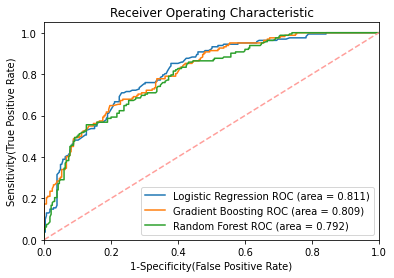

In [50]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Logistic Regression',
    'probs': logreg_probs_test[:,1]
},
{
    'label': 'Gradient Boosting',
    'probs': xg_probs_test
},
{
    'label': 'Random Forest',
    'probs': rf_probs_test[:,1]
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = bankloan_test_noWoE['Default'], 
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(bankloan_test_WoE['Default'], 
                                           m['probs'])
  plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
                 

    
# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
    
# Plot!    
plt.show()

Interesting results, no?

I introduced several new concepts here. First, a dictionary. A dictionary is a very useful structure, which allows to have values indexed by a name. Every item will have their own values for its name, here the 'label' and 'probs'. I use this as an input for the for loop.

Second, check the part

```
label='%s ROC (area = %0.3f)' % (m['label'], auc)
```

of the plot definition. Note the ```%s``` and ```%0.3f``` in the string. This is a magic command that tells Python "this is a variable, in a certain format. Go look for it outside and match it in order". So in this case we have two:

- An ```%s``` which means 'This is a string'.
- A ```%0.3f``` which means 'This is a float (decimal), and I want it formatted using three decimals'.

Outside the string there is a ```% (m['label'], auc)```. This is matched one by one, the ```%s``` to the ```m['label']``` (the string), and the ```%0.3f``` to the ```auc```. This way I can create dynamically labels. Remember to use these tricks to simplify your life! 